In [1]:
import pandas as pd
import re
from tqdm.notebook import tqdm
from difflib import SequenceMatcher

pd.set_option('max_colwidth', 40)
pd.set_option('display.max_rows', 40)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
!ls ../..

data  environment.yml  models  notebooks  seefood  spiders


In [4]:
df = pd.read_csv("../../data/sparkrecipes_complete.csv").drop_duplicates()

In [5]:
df.id.nunique()

608597

In [6]:
df.head(5)

,id,title,image_url,ingredients,url,servings,ingredient_calories,Calories,Total Fat,Saturated Fat,...,Iron,Magnesium,Manganese,Niacin,Pantothenic Acid,Phosphorus,Riboflavin,Selenium,Thiamin,Zinc
0,5,20-Minute Chicken Creole,https://sparkpeo.hs.llnwd.net/e1/res...,nonstick cooking spray as needed|||4...,https://recipes.sparkpeople.com/reci...,1.0,152 calories of Chicken Breast (cook...,269.3,6.3 g,1.9 g,...,15.7 %,17.6 %,19.6 %,78.2 %,15.1 %,33.0 %,13.9 %,33.3 %,16.8 %,12.0 %
1,3,Caribbean Black Beans and Rice,NaN,|||1 lb. dry black beans|||7 cups wa...,https://recipes.sparkpeople.com/reci...,NaN,"227 calories of Beans, black, (1 cup...",479.6,3.9 g,0.6 g,...,32.9 %,36.8 %,81.8 %,16.9 %,11.1 %,32.9 %,8.2 %,20.5 %,47.2 %,18.9 %
2,6,Beef and Vegetable Stir-Fry,NaN,|||\n2 tablespoons dry red wine |||\...,https://recipes.sparkpeople.com/reci...,NaN,"100 calories of Beef, round steak, (...",245.5,10.2 g,1.5 g,...,11.5 %,8.9 %,13.1 %,22.1 %,6.9 %,21.8 %,16.2 %,25.3 %,11.0 %,16.7 %
3,7,Italian Vegetable Bake,https://sparkpeo.hs.llnwd.net/e1/res...,|||1 can (28 oz.) whole tomatoes ||...,https://recipes.sparkpeople.com/reci...,NaN,"8 calories of Canned Tomatoes, (0.25...",37.2,0.2 g,0.1 g,...,4.0 %,8.3 %,21.9 %,4.6 %,2.2 %,4.5 %,3.8 %,1.2 %,6.6 %,2.4 %
4,8,Carrot-Raisin Bread,NaN,|||1-1/2 cups sifted all-purpose flo...,https://recipes.sparkpeople.com/reci...,NaN,"40 calories of Wheat flour, white, b...",100.1,1.4 g,0.1 g,...,3.5 %,1.3 %,7.5 %,4.3 %,0.6 %,2.1 %,3.8 %,6.6 %,6.7 %,1.0 %


In [7]:
df.drop(["image_url"], axis=1, inplace=True)

In [8]:
df.isna().mean().plot.bar(figsize=(10, 5));

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(604158, 37)

In [11]:
df.dtypes

id                       int64
title                   object
ingredients             object
url                     object
servings               float64
ingredient_calories     object
Calories                object
Total Fat               object
Saturated Fat           object
Polyunsaturated Fat     object
Monounsaturated Fat     object
Cholesterol             object
Sodium                  object
Potassium               object
Total Carbohydrate      object
Dietary Fiber           object
Sugars                  object
Protein                 object
Vitamin A               object
Vitamin B-12            object
Vitamin B-6             object
Vitamin C               object
Vitamin D               object
Vitamin E               object
Calcium                 object
Copper                  object
Folate                  object
Iron                    object
Magnesium               object
Manganese               object
Niacin                  object
Pantothenic Acid        object
Phosphor

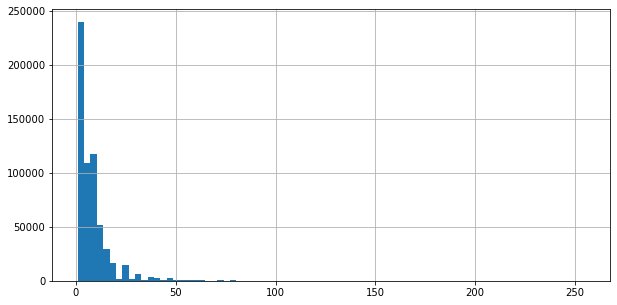

In [12]:
df.servings.fillna(0.0).hist(bins=80, figsize=(10, 5));

In [13]:
df.shape

(604158, 37)

## Preprocess Total Calories

In [14]:
df["total_calories"] = df["Calories"].apply(lambda x: float(x.replace(",", ""))) 
df = df[df.total_calories <= 1000]

In [15]:
df.head() 

,id,title,ingredients,url,servings,ingredient_calories,Calories,Total Fat,Saturated Fat,Polyunsaturated Fat,...,Magnesium,Manganese,Niacin,Pantothenic Acid,Phosphorus,Riboflavin,Selenium,Thiamin,Zinc,total_calories
0,5,20-Minute Chicken Creole,nonstick cooking spray as needed|||4...,https://recipes.sparkpeople.com/reci...,1.0,152 calories of Chicken Breast (cook...,269.3,6.3 g,1.9 g,1.1 g,...,17.6 %,19.6 %,78.2 %,15.1 %,33.0 %,13.9 %,33.3 %,16.8 %,12.0 %,269.3
7,11,Corn Chowder,1 tablespoon olive oil|||2 tablespoo...,https://recipes.sparkpeople.com/reci...,1.0,"51 calories of Milk, 1%, (0.50 cup)|...",202.5,5.3 g,1.1 g,1.4 g,...,10.4 %,12.8 %,11.6 %,7.6 %,19.2 %,20.7 %,14.3 %,14.5 %,7.2 %,202.5
13,19,Turkey Stuffed Cabbage,1 head cabbage||| 1/2 lb. lea...,https://recipes.sparkpeople.com/reci...,10.0,"63 calories of Ground Beef (lean), (...",155.5,6.2 g,2.1 g,0.4 g,...,9.3 %,15.2 %,9.4 %,3.2 %,8.5 %,7.2 %,11.7 %,6.9 %,11.1 %,155.5
15,21,Chicken Marsala,1/8 teaspoon black pepper|||1/4 teas...,https://recipes.sparkpeople.com/reci...,1.0,214 calories of Chicken Breast (cook...,304.0,8.4 g,1.7 g,1.4 g,...,14.3 %,11.0 %,106.6 %,17.8 %,37.5 %,17.4 %,53.6 %,15.6 %,10.9 %,304.0
19,25,Easy Lemon Chicken,"1-1/2 lb. chicken breast, skinned an...",https://recipes.sparkpeople.com/reci...,4.0,286 calories of Chicken Breast (cook...,318.0,6.7 g,1.7 g,1.4 g,...,20.2 %,5.3 %,133.3 %,21.6 %,48.8 %,15.3 %,60.5 %,14.9 %,13.8 %,318.0


In [16]:
df_base = df[["id", "title", "total_calories", "url", "servings"]]
df_base.head()

,id,title,total_calories,url,servings
0,5,20-Minute Chicken Creole,269.3,https://recipes.sparkpeople.com/reci...,1.0
7,11,Corn Chowder,202.5,https://recipes.sparkpeople.com/reci...,1.0
13,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/reci...,10.0
15,21,Chicken Marsala,304.0,https://recipes.sparkpeople.com/reci...,1.0
19,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/reci...,4.0


In [17]:
df_base.columns = ["recipe_id", "title", "total_calories", "url", "servings"]
df_base.head()

,recipe_id,title,total_calories,url,servings
0,5,20-Minute Chicken Creole,269.3,https://recipes.sparkpeople.com/reci...,1.0
7,11,Corn Chowder,202.5,https://recipes.sparkpeople.com/reci...,1.0
13,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/reci...,10.0
15,21,Chicken Marsala,304.0,https://recipes.sparkpeople.com/reci...,1.0
19,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/reci...,4.0


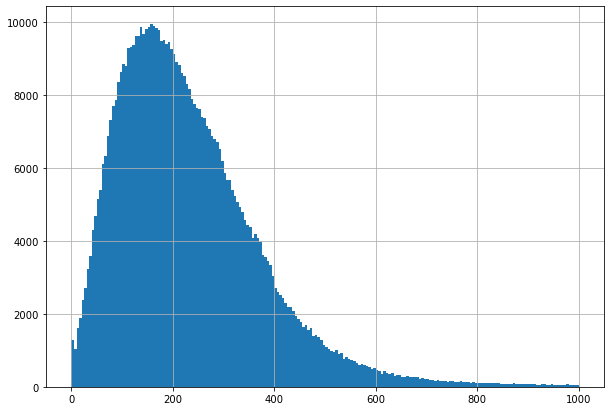

In [18]:
df_base.total_calories.hist(bins=200, figsize=(10, 7))

In [19]:
df_base.describe()

,recipe_id,total_calories,servings
count,5.943660e+05,594366.000000,594366.000000
mean,1.386698e+06,231.076939,8.666781
std,9.175214e+05,141.662089,10.609149
min,5.000000e+00,0.000000,1.000000
25%,5.608360e+05,128.400000,4.000000
50%,1.303338e+06,205.700000,6.000000
75%,2.148266e+06,305.000000,10.000000
max,3.199977e+06,1000.000000,255.000000


## Preprocess Ingredients

In [20]:
df.ingredient_calories.values[0].split("|||")

['152 calories of Chicken Breast (cooked), no skin, roasted, (0.53 breast, bone and skin removed)',
 '69 calories of Nestle Chef Mate Hot Dog Chili Sauce, (0.25 cup)',
 '19 calories of Red Ripe Tomatoes, (0.50 cup, chopped or sliced)',
 '13 calories of Sweet peppers (bell), (0.33 cup, chopped)',
 '6 calories of Lemon juice, (1 fl oz)',
 '4 calories of Onions, raw, (0.06 cup, chopped)',
 '3 calories of Celery, raw, (0.15 cup, diced)',
 '2 calories of Garlic, (0.50 clove)',
 '1 calories of Parsley, (0.50 tbsp)',
 '0 calories of Basil, (0.50 tbsp)',
 '0 calories of Peppers, sweet, red, fresh, (0.06 tbsp)',
 '0 calories of Salt, (0.06 tsp)']

In [21]:
df_ing_cal = pd.DataFrame(df.ingredient_calories.str.rsplit(r"|||").tolist()).stack().reset_index([0]).reset_index(drop=True)
df_ing_cal.columns = ["recipe_id", "ingredient"]
df_ing_cal

,recipe_id,ingredient
0,0,152 calories of Chicken Breast (cook...
1,0,69 calories of Nestle Chef Mate Hot ...
2,0,"19 calories of Red Ripe Tomatoes, (0..."
3,0,"13 calories of Sweet peppers (bell),..."
4,0,"6 calories of Lemon juice, (1 fl oz)"
...,...,...
4346203,594365,80 calories of Southern Grove Chia S...
4346204,594365,44 calories of brancourts cottage ch...
4346205,594365,37 calories of Speedy Berry Blueberr...
4346206,594365,35 calories of Flaxseed (Spectrum) O...


In [22]:
df_ing_cal_fine = pd.DataFrame(df_ing_cal.ingredient.str.split("calories of").tolist(), index=df_ing_cal.index)
df_ing_cal_fine.columns = ["calories", "ingredient"]
df_ing_cal_fine = df_ing_cal_fine.join(df_ing_cal[["recipe_id"]])
df_ing_cal_fine

,calories,ingredient,recipe_id
0,152,"Chicken Breast (cooked), no skin, r...",0
1,69,Nestle Chef Mate Hot Dog Chili Sauc...,0
2,19,"Red Ripe Tomatoes, (0.50 cup, chopp...",0
3,13,"Sweet peppers (bell), (0.33 cup, ch...",0
4,6,"Lemon juice, (1 fl oz)",0
...,...,...,...
4346203,80,"Southern Grove Chia Seeds, (1 tbsp)",594365
4346204,44,"brancourts cottage cheese, (50 serv...",594365
4346205,37,"Speedy Berry Blueberries, (75 serving)",594365
4346206,35,"Flaxseed (Spectrum) Organic Ground,...",594365


In [23]:
def extract_addon(input_str):
    open_bracket_ctr = 0
    inner_chars = []
    bracket_text = []
    for c in input_str:
        if c == "(":
            open_bracket_ctr += 1
            inner_chars.append("(")
        elif c == ")":
            open_bracket_ctr -= 1
            inner_chars.append(")")
            if open_bracket_ctr == 0:
                bracket_text.append(inner_chars)
                inner_chars = []
        elif open_bracket_ctr >= 1:
            inner_chars.append(c)
    result = ["".join(x).strip() for x in bracket_text]
    if len(result) > 0:
        return result[-1][1:-1]
    else:
        return None

In [24]:
extract_addon("balsamic vinegar, (0.08 tablespoon)")

'0.08 tablespoon'

In [25]:
extract_addon('Sweet peppers (bell), (0.17 medium (approx 2-3/4" long, 2-1/2" dia))')

'0.17 medium (approx 2-3/4" long, 2-1/2" dia)'

In [26]:
def extract_amount(ingredient):
    amount_p = extract_addon(ingredient)
    amount_p_addon = extract_addon(amount_p) if amount_p else None
    amount_pp = amount_p.replace(f"({amount_p_addon})", "") if amount_p else None
    amount_ppp = amount_pp.split(",")[0] if amount_pp else None
    
    if amount_ppp:
        match = re.search(r'([0-9]+(\.[0-9]+)?)\s(.*)', amount_ppp, re.IGNORECASE)
        if match:
            return match.group(1), match.group(3), amount_p_addon
    return amount_ppp, None, amount_p_addon

def process_ingredient(ingredient):
    ingredient_p = ingredient.replace(f"({extract_addon(ingredient)})", "")[:-2]
    ingredient_p_addon = extract_addon(ingredient_p)
    ingredient_pp = ingredient_p.replace(f"({ingredient_p_addon})", "") if ingredient else None
    ingredient_ppp = ingredient_pp.split(",")[0] if ingredient_pp else None
    ingredient_pp_addon =  ",".join(ingredient_pp.split(",")[1:])
    ingredient_pp_addon_p = None if ingredient_pp_addon == "" else ingredient_pp_addon
    return ingredient_ppp, ingredient_pp_addon_p, ingredient_p_addon

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [27]:
df_fine_amount = pd.DataFrame(df_ing_cal_fine["ingredient"].map(lambda x: extract_amount(x)).tolist(), index=df_ing_cal_fine.index)
df_fine_amount.columns = ["amount", "unit", "unit_addon"]
df_fine_ingredient = pd.DataFrame(df_ing_cal_fine["ingredient"].map(lambda x: process_ingredient(x)).tolist(), index=df_ing_cal_fine.index)
df_fine_ingredient.columns = ["ingredient_name", "ingredient_addon_a", "ingredient_addon_b"]

In [28]:
df_ing_complete = df_ing_cal_fine[["recipe_id", "ingredient", "calories"]].join(df_fine_amount).join(df_fine_ingredient)
df_ing_complete["calories"] = df_ing_complete["calories"].str.replace(",", "").astype(float)
df_ing_complete["amount"] = df_ing_complete["amount"].map(lambda x: float(x) if x and isfloat(x) else None)

In [29]:
df_ing_complete

,recipe_id,ingredient,calories,amount,unit,unit_addon,ingredient_name,ingredient_addon_a,ingredient_addon_b
0,0,"Chicken Breast (cooked), no skin, r...",152.0,0.53,breast,None,Chicken Breast,"no skin, roasted",cooked
1,0,Nestle Chef Mate Hot Dog Chili Sauc...,69.0,0.25,cup,None,Nestle Chef Mate Hot Dog Chili Sauce,None,None
2,0,"Red Ripe Tomatoes, (0.50 cup, chopp...",19.0,0.50,cup,None,Red Ripe Tomatoes,None,None
3,0,"Sweet peppers (bell), (0.33 cup, ch...",13.0,0.33,cup,None,Sweet peppers,None,bell
4,0,"Lemon juice, (1 fl oz)",6.0,1.00,fl oz,None,Lemon juice,None,None
...,...,...,...,...,...,...,...,...,...
4346203,594365,"Southern Grove Chia Seeds, (1 tbsp)",80.0,1.00,tbsp,None,Southern Grove Chia Seeds,None,None
4346204,594365,"brancourts cottage cheese, (50 serv...",44.0,50.00,serving,None,brancourts cottage cheese,None,None
4346205,594365,"Speedy Berry Blueberries, (75 serving)",37.0,75.00,serving,None,Speedy Berry Blueberries,None,None
4346206,594365,"Flaxseed (Spectrum) Organic Ground,...",35.0,1.00,tbsp,None,Flaxseed Organic Ground,None,Spectrum


### Analyze calories and amounts

In [30]:
df_ing_complete.dtypes

recipe_id               int64
ingredient             object
calories              float64
amount                float64
unit                   object
unit_addon             object
ingredient_name        object
ingredient_addon_a     object
ingredient_addon_b     object
dtype: object

In [31]:
df_ing_complete[["calories", "amount"]].describe()

,calories,amount
count,4.346208e+06,4.344438e+06
mean,3.175185e+01,2.413294e+00
std,6.039126e+01,1.487369e+01
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e-01
50%,1.200000e+01,2.500000e-01
75%,3.900000e+01,6.700000e-01
max,3.727400e+04,4.000000e+03


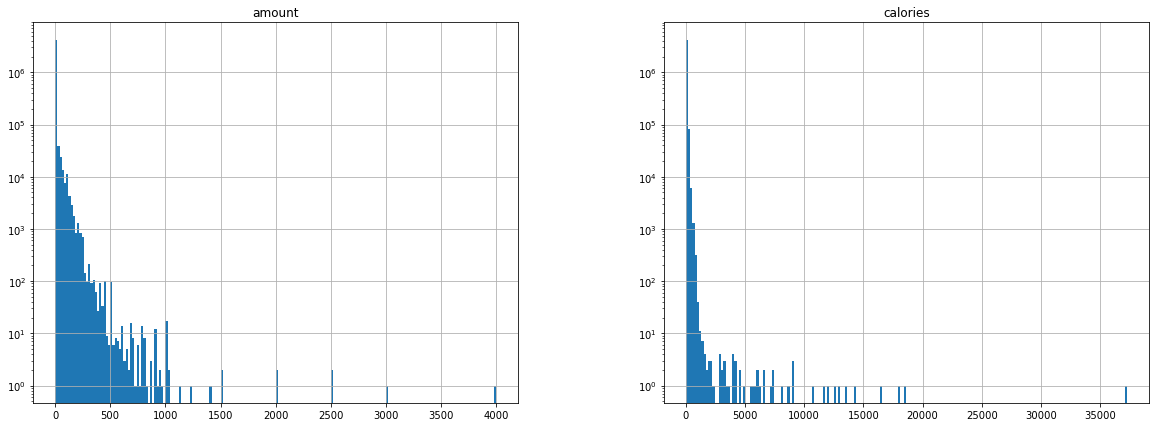

In [32]:
df_ing_complete[["calories", "amount"]].hist(bins=200, figsize=(20, 7), log=True);

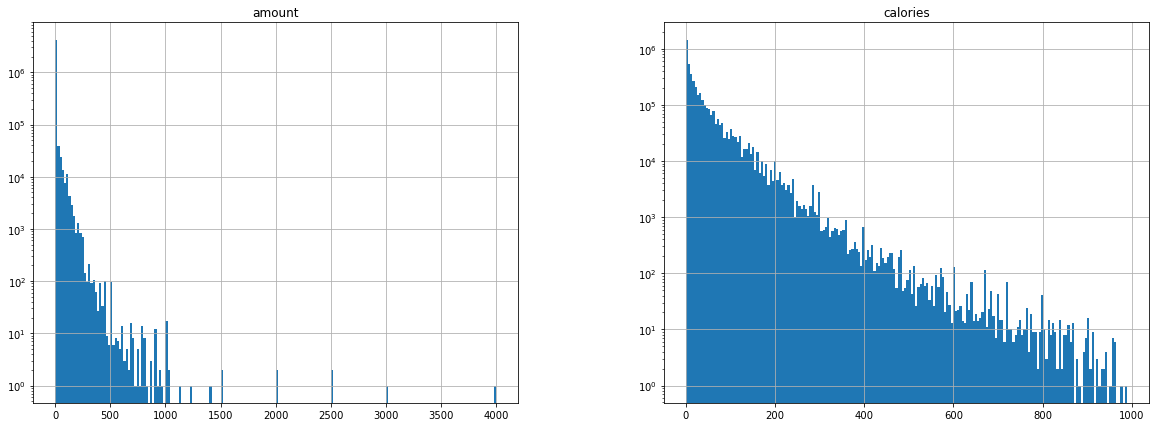

In [33]:
df_ing_complete[df_ing_complete.calories < 1000][["calories", "amount"]].hist(bins=200, figsize=(20, 7), log=True);

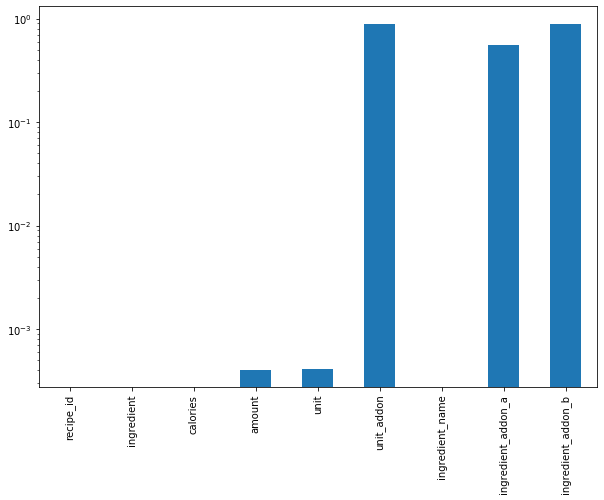

In [34]:
df_ing_complete.isna().mean().plot.bar(log=True, figsize=(10, 7));

### Normalize calories

In [35]:
df_ing_complete["norm_calories"] = df_ing_complete["calories"] /  df_ing_complete["amount"] 

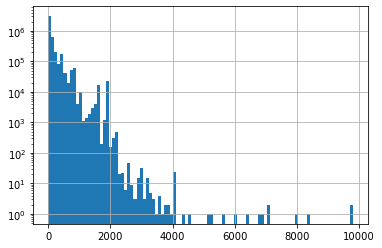

In [36]:
df_ing_complete["norm_calories"].hist(bins=100, log=True);

In [37]:
df_ing_complete[df_ing_complete.norm_calories > 1000]

,recipe_id,ingredient,calories,amount,unit,unit_addon,ingredient_name,ingredient_addon_a,ingredient_addon_b,norm_calories
93,12,"Olive Oil, (0.01 cup)",19.0,0.01,cup,None,Olive Oil,None,None,1900.000000
128,16,"Beef, tenderloin, (0.25 lb)",282.0,0.25,lb,None,Beef,tenderloin,None,1128.000000
189,26,"Olive Oil, (0.03 cup)",57.0,0.03,cup,None,Olive Oil,None,None,1900.000000
201,28,"Honey, (0.13 cup)",134.0,0.13,cup,None,Honey,None,None,1030.769231
238,33,"Olive Oil, (0.02 cup)",38.0,0.02,cup,None,Olive Oil,None,None,1900.000000
...,...,...,...,...,...,...,...,...,...,...
4345479,594271,"Digiorno Basil Pesto Sauce, (0.19 cup)",236.0,0.19,cup,None,Digiorno Basil Pesto Sauce,None,None,1242.105263
4345714,594300,"Canola Oil, (0.01 cup)",19.0,0.01,cup,None,Canola Oil,None,None,1900.000000
4345850,594320,"Olive Oil, (0.25 cup)",477.0,0.25,cup,None,Olive Oil,None,None,1908.000000
4345998,594339,"Butter, unsalted, (0.04 cup)",65.0,0.04,cup,None,Butter,unsalted,None,1625.000000


### Normalize units

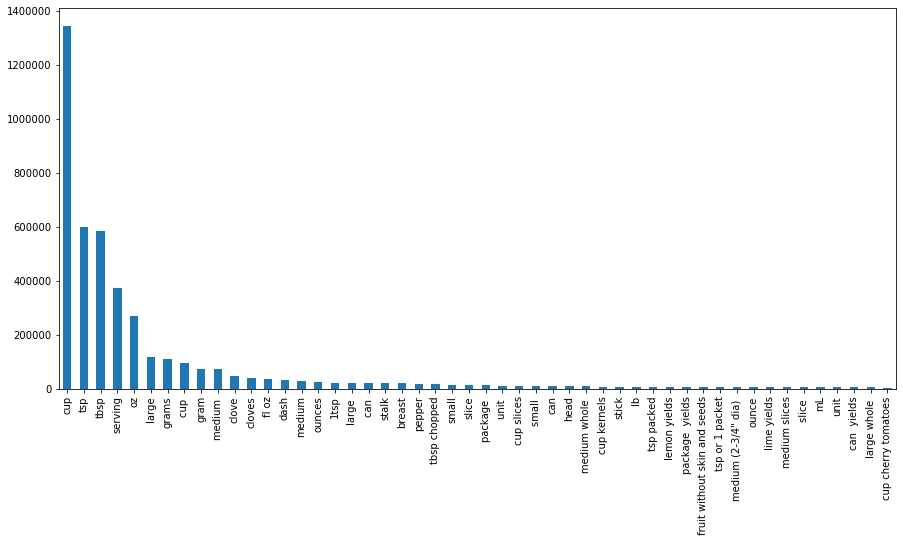

In [38]:
df_ing_complete["unit"].value_counts().nlargest(50).plot.bar(figsize=(15, 7));

In [39]:
df_ing_complete['unit'].unique()

array(['breast', 'cup', 'fl oz', 'clove', 'tbsp', 'tsp', 'cup kernels',
       'cup diced', 'tbsp chopped', 'oz', 'head', 'slice', 'large',
       'medium', 'fruit without seeds', 'medium ', 'large ', 'cup ',
       'grams', None, 'small ', 'fruit ', 'fruit without skin',
       'patty (4 oz', 'lb', '1tsp', 'can ', 'cup chips ',
       'medium (2-3/4" dia) ', 'pepper', 'lime yields', 'ear', 'carrot ',
       'can', 'stalk', 'dash', 'sweetpotato', 'tsp packed', 'ounces',
       'small', 'pear', 'tsp or 1 packet', 'unit', 'medium whole ',
       'large (3-1/4" dia) ', 'fruit', 'unit ', 'cucumber ', 'glass ',
       'package ', 'cup mini chips', 'Serving', 'serving', 'container',
       'extra large', 'beet ', 'cup cherry tomatoes', 'large whole ',
       'cup elbow shaped', 'fruit without refuse', 'tortilla ',
       'tortilla', 'Italian tomato', 'cloves', 'lemon yields',
       'slice or wedge', 'grape', 'pat ', 'spear', 'eggplant', 'leaves',
       'medium slices', 'can  yields', 'cup 

In [40]:
f"Number of unique units: {df_ing_complete['unit'].unique().shape[0]}"

'Number of unique units: 440'

In [41]:
df_ing_complete[df_ing_complete["unit"].isna()]

,recipe_id,ingredient,calories,amount,unit,unit_addon,ingredient_name,ingredient_addon_a,ingredient_addon_b,norm_calories
77,10,"Baked Potato, with skin, (0.50 larg...",139.0,NaN,None,None,Baked Potato,"with skin, (0.50 large (3"" to 4-1/4...",None,NaN
3215,482,"Baked Potato, with skin, (1 large (...",278.0,NaN,None,None,Baked Potato,"with skin, (1 large (3"" to 4-1/4"" dia",None,NaN
7136,1083,"Baked Potato, with skin, (1 large (...",278.0,NaN,None,None,Baked Potato,"with skin, (1 large (3"" to 4-1/4"" dia",None,NaN
12797,1967,"Baked Potato, with skin, (1 large (...",278.0,NaN,None,None,Baked Potato,"with skin, (1 large (3"" to 4-1/4"" dia",None,NaN
12808,1968,Great Value Sugar Free Lemonade Nat...,0.0,NaN,None,None,Great Value Sugar Free Lemonade Nat...,(0.20 cu,None,NaN
...,...,...,...,...,...,...,...,...,...,...
4336110,592933,Knorr Vegetable Stockpot Concentrat...,6.0,NaN,None,None,Knorr Vegetable Stockpot Concentrat...,(5.60 gra,None,NaN
4336492,592993,Organic blond coconut sugar (big tr...,50.0,NaN,None,None,Organic blond coconut sugar (big tr...,(12.50 gra,None,NaN
4342809,593901,"Baked Potato, with skin, (0.17 larg...",47.0,NaN,None,None,Baked Potato,"with skin, (0.17 large (3"" to 4-1/4...",None,NaN
4343826,594041,"Dates, Hadley Pitted Deglet Noor (5...",72.0,NaN,None,None,Dates,Hadley Pitted Deglet Noor (5 Dates/...,None,NaN


* lowercase vs. uppercase (x)
* strip (x)
* tbsp, tsp, tablespoon, tbs, Tbspn
* cup X
* tbsp X
* 1tsp
* None?
* X or Y

In [42]:
MIN_UNIT_COUNT = 300

tablespoon_abbrev = ["tbsp", "tablespoon", "tbs"]
teaspoon_abbrev = ["tsp", "teaspoon"]
cup_abbrev = ["cup"]
oz_abbrev = ["oz", "fl oz"]

def norm_unit(abbrev, target, unit):
    if any([a in unit for a in abbrev]):
        return target
    else:
        return unit

In [43]:
df_ing_complete["norm_unit"] = (
    df_ing_complete["unit"]
    .str.strip()
    .str.lower()
    .map(lambda x: norm_unit(tablespoon_abbrev, "tablespoon", x) if x else None)
    .map(lambda x: norm_unit(teaspoon_abbrev, "teaspoon", x) if x else None)
    .map(lambda x: norm_unit(cup_abbrev, "cup", x) if x else None)
    .map(lambda x: norm_unit(oz_abbrev, "oz", x) if x else None)
)
unit_counts = df_ing_complete["norm_unit"].value_counts()
df_ing_complete["norm_unit"] = df_ing_complete["norm_unit"].map(lambda x: "generic_unit" if x and unit_counts[x] <= MIN_UNIT_COUNT else x)

In [44]:
f"Number of unique (normalized) units: {df_ing_complete['norm_unit'].unique().shape[0]}"

'Number of unique (normalized) units: 115'

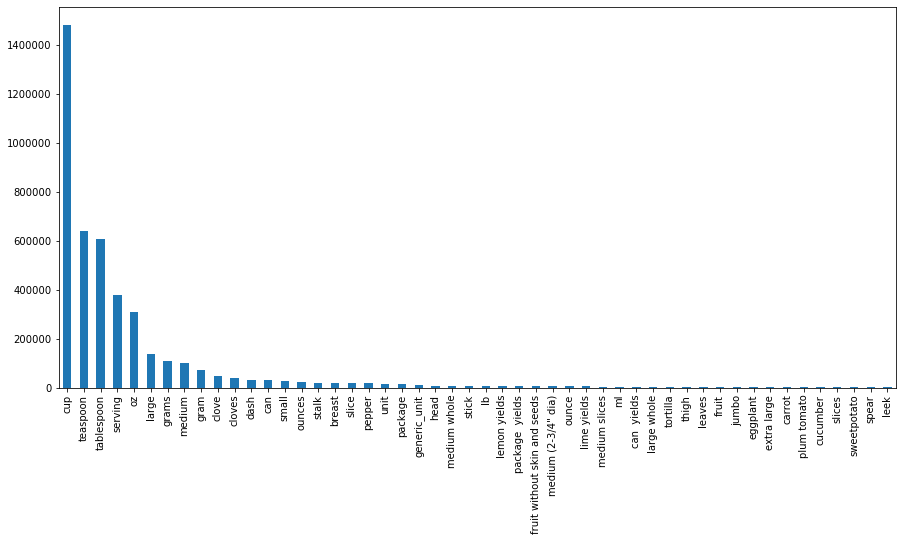

In [45]:
df_ing_complete["norm_unit"].value_counts().nlargest(50).plot.bar(figsize=(15, 7));

In [46]:
df_ing_complete["norm_unit"].unique()

array(['breast', 'cup', 'oz', 'clove', 'tablespoon', 'teaspoon', 'head',
       'slice', 'large', 'medium', 'fruit without seeds', 'grams', None,
       'small', 'fruit', 'fruit without skin', 'lb', 'can',
       'medium (2-3/4" dia)', 'pepper', 'lime yields', 'ear', 'carrot',
       'stalk', 'dash', 'sweetpotato', 'ounces', 'pear', 'unit',
       'medium whole', 'large (3-1/4" dia)', 'cucumber', 'glass',
       'package', 'serving', 'container', 'extra large', 'beet',
       'large whole', 'fruit without refuse', 'tortilla',
       'italian tomato', 'cloves', 'lemon yields', 'generic_unit',
       'grape', 'pat', 'spear', 'eggplant', 'leaves', 'medium slices',
       'can  yields', 'cracker', 'wedge yields', 'tomato',
       'small (2-1/2" dia)', 'small box', 'leaf', 'muffin', 'drumstick',
       'piece', 'miniature box', 'berries', 'stick', 'inner leaf',
       'package  yields', 'thigh', 'strips', 'bunch', 'block', 'potato',
       'fillet', 'can or bottle', 'leek', 'gram', 'sprigs'

In [47]:
df_ing_complete["norm_unit"].value_counts()

cup                                                                   1478926
teaspoon                                                               637591
tablespoon                                                             608488
serving                                                                377416
oz                                                                     309810
                                                                       ...   
large rectangular piece or 2 squares or 4 small rectangular pieces        368
quart                                                                     349
leg                                                                       338
cubic inch                                                                337
large (2-3/4" dia)                                                        321
Name: norm_unit, Length: 114, dtype: int64

### Normalize ingredient names

In [48]:
df_ing_complete["norm_ingredient_name"] = df_ing_complete["ingredient_name"].str.strip().str.lower()
df_ing_complete["norm_ingredient_name"]

0                                chicken breast
1          nestle chef mate hot dog chili sauce
2                             red ripe tomatoes
3                                 sweet peppers
4                                   lemon juice
                           ...                 
4346203               southern grove chia seeds
4346204               brancourts cottage cheese
4346205                speedy berry blueberries
4346206                flaxseed  organic ground
4346207                    morelife maca powder
Name: norm_ingredient_name, Length: 4346208, dtype: object

In [49]:
df_ing_complete["norm_ingredient_name"].unique().shape

(205838,)

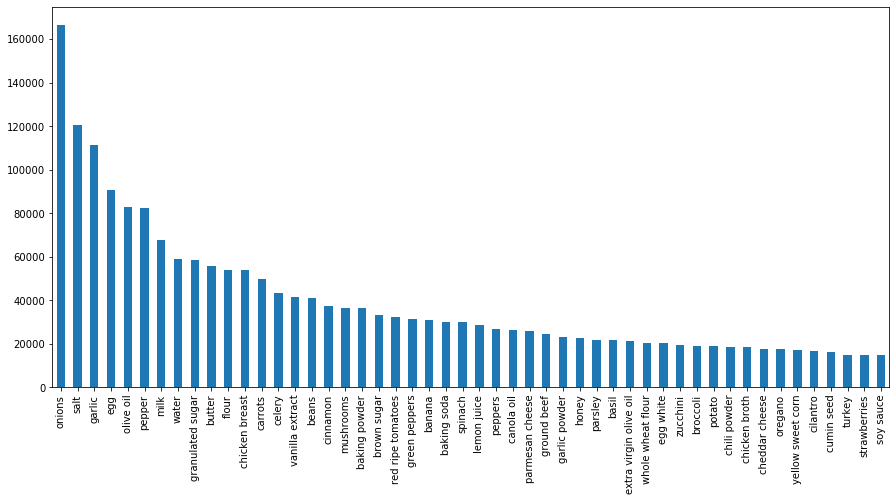

In [50]:
df_ing_complete["norm_ingredient_name"].value_counts().nlargest(50).plot.bar(figsize=(15, 7));

In [51]:
df_ing_stats = df_ing_complete[["norm_ingredient_name", "calories"]].groupby(["norm_ingredient_name"]).agg(["count", "mean", "sum", "std", "median"])
df_ing_stats.sort_values(by=[("calories", "std")], ascending=True)

calories                        
                                     count  mean   sum  std median
norm_ingredient_name                                              
italian herb seasoning mix              94   0.0   0.0  0.0    0.0
betty crocker instant potato buds        2  14.0  28.0  0.0   14.0
sugar free french vanilla creamer        3  30.0  90.0  0.0   30.0
dry mixed herbs                         13   0.0   0.0  0.0    0.0
dry milk - great value                   2   0.0   0.0  0.0    0.0
...                                    ...   ...   ...  ...    ...
•3/4 teaspoon salt                       1   0.0   0.0  NaN    0.0
•4-1/2 cups cooked egg noodles           1   0.0   0.0  NaN    0.0
•6 bone-in pork loin chops               1   0.0   0.0  NaN    0.0
고추장 - hot pepper paste                   1   8.0   8.0  NaN    8.0
미역                                       1   3.0   3.0  NaN    3.0

[205838 rows x 5 columns]

In [52]:
with pd.option_context('display.max_rows', 10):
    df_ing_stats[df_ing_stats["calories", "std"] > 0.0].sample(10)

calories                      \
                                           count        mean     sum   
norm_ingredient_name                                                   
one  whole bannanna                            3   57.000000   171.0   
mediterranean organic sundried tomatoes        3    6.000000    18.0   
activia yogurt                                 4   42.750000   171.0   
goya beans - central american red              2   69.500000   139.0   
avocado - medium 1 srv = 1 medium              2  207.000000   414.0   
beer                                          70   19.028571  1332.0   
coconut/palm sugar                            29   11.482759   333.0   
yoplait greek plain yogurt 2x protein          2   24.000000    48.0   
tomatoe                                      251   11.362550  2852.0   
silk organic soy milk unsweetened              9   22.000000   198.0   

                                                           
                                               std median  
norm_ingredient_name                                       
one  whole bannanna                      52.028838   55.0  
mediterranean organic sundried tomatoes   4.582576    5.0  
activia yogurt                           26.183646   47.0  
goya beans - central american red        13.435029   69.5  
avocado - medium 1 srv = 1 medium        97.580736  207.0  
beer                                     18.451638   14.0  
coconut/palm sugar                       12.662150    8.0  
yoplait greek plain yogurt 2x protein    16.970563   24.0  
tomatoe                                  14.649779    6.0  
silk organic soy milk unsweetened        24.530593   20.0

In [53]:
df_ing_complete[df_ing_complete.norm_ingredient_name == "ground beef"]

,recipe_id,ingredient,calories,amount,unit,unit_addon,ingredient_name,ingredient_addon_a,ingredient_addon_b,norm_calories,norm_unit,norm_ingredient_name
21,2,"Ground Beef (lean), (0.80 oz)",63.0,0.80,oz,None,Ground Beef,None,lean,78.750000,oz,ground beef
822,115,"Ground beef, lean, (1 oz)",75.0,1.00,oz,None,Ground beef,lean,None,75.000000,oz,ground beef
873,124,"Ground beef, lean, (4 oz)",299.0,4.00,oz,None,Ground beef,lean,None,74.750000,oz,ground beef
1351,200,"Ground beef, lean, (1.50 oz)",112.0,1.50,oz,None,Ground beef,lean,None,74.666667,oz,ground beef
1379,204,"Ground beef, extra lean (15% fat) p...",146.0,2.00,oz,None,Ground beef,extra lean pan broiled,15% fat,73.000000,oz,ground beef
...,...,...,...,...,...,...,...,...,...,...,...,...
4345302,594246,"Ground beef, extra lean (15% fat) p...",511.0,7.00,oz,None,Ground beef,extra lean pan broiled,15% fat,73.000000,oz,ground beef
4345335,594250,"Ground beef, lean, (2.67 oz)",200.0,2.67,oz,None,Ground beef,lean,None,74.906367,oz,ground beef
4345500,594274,"Ground beef, lean, (1.60 oz)",120.0,1.60,oz,None,Ground beef,lean,None,75.000000,oz,ground beef
4345666,594295,"Ground beef, extra lean (15% fat) p...",49.0,0.67,oz,None,Ground beef,extra lean pan broiled,15% fat,73.134328,oz,ground beef


### Analyze long ingredient names

In [54]:
df_ing_complete[["norm_ingredient_name", "calories"]][df_ing_complete.norm_ingredient_name.str.len() >= 30]["norm_ingredient_name"].unique().shape[0]

103670

### Persist dataframes for further analysis

In [55]:
df_base

,recipe_id,title,total_calories,url,servings
0,5,20-Minute Chicken Creole,269.3,https://recipes.sparkpeople.com/reci...,1.0
7,11,Corn Chowder,202.5,https://recipes.sparkpeople.com/reci...,1.0
13,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/reci...,10.0
15,21,Chicken Marsala,304.0,https://recipes.sparkpeople.com/reci...,1.0
19,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/reci...,4.0
...,...,...,...,...,...
608597,3199939,2 FEV 17 Lemon cheese cake fat bomb,122.9,https://recipes.sparkpeople.com/reci...,14.0
608598,3199943,Lentil soup,117.8,https://recipes.sparkpeople.com/reci...,6.0
608599,3199965,White chocolate cranberry mug cake,464.4,https://recipes.sparkpeople.com/reci...,1.0
608600,3199966,THM Turtle Bars,301.1,https://recipes.sparkpeople.com/reci...,16.0


In [56]:
df_base.to_csv("../../data/sparkrecipes_base.csv", index=False)

In [57]:
df_ing_complete

,recipe_id,ingredient,calories,amount,unit,unit_addon,ingredient_name,ingredient_addon_a,ingredient_addon_b,norm_calories,norm_unit,norm_ingredient_name
0,0,"Chicken Breast (cooked), no skin, r...",152.0,0.53,breast,None,Chicken Breast,"no skin, roasted",cooked,286.792453,breast,chicken breast
1,0,Nestle Chef Mate Hot Dog Chili Sauc...,69.0,0.25,cup,None,Nestle Chef Mate Hot Dog Chili Sauce,None,None,276.000000,cup,nestle chef mate hot dog chili sauce
2,0,"Red Ripe Tomatoes, (0.50 cup, chopp...",19.0,0.50,cup,None,Red Ripe Tomatoes,None,None,38.000000,cup,red ripe tomatoes
3,0,"Sweet peppers (bell), (0.33 cup, ch...",13.0,0.33,cup,None,Sweet peppers,None,bell,39.393939,cup,sweet peppers
4,0,"Lemon juice, (1 fl oz)",6.0,1.00,fl oz,None,Lemon juice,None,None,6.000000,oz,lemon juice
...,...,...,...,...,...,...,...,...,...,...,...,...
4346203,594365,"Southern Grove Chia Seeds, (1 tbsp)",80.0,1.00,tbsp,None,Southern Grove Chia Seeds,None,None,80.000000,tablespoon,southern grove chia seeds
4346204,594365,"brancourts cottage cheese, (50 serv...",44.0,50.00,serving,None,brancourts cottage cheese,None,None,0.880000,serving,brancourts cottage cheese
4346205,594365,"Speedy Berry Blueberries, (75 serving)",37.0,75.00,serving,None,Speedy Berry Blueberries,None,None,0.493333,serving,speedy berry blueberries
4346206,594365,"Flaxseed (Spectrum) Organic Ground,...",35.0,1.00,tbsp,None,Flaxseed Organic Ground,None,Spectrum,35.000000,tablespoon,flaxseed organic ground


In [58]:
df_ing_complete.to_csv("../../data/sparkrecipes_ingredients.csv", index=False)